In [1]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

import requests
import gmaps
import os
from pprint import pprint

#import api key
from api_keys import g_key

In [2]:
#create dataframe from csv of breweries, courtesy of OpenBreweryDB (https://github.com/openbrewerydb/openbrewerydb)
brews_df = pd.read_csv ('openbrewerydb.csv')

#isolate breweries in the state of georgia
ga_brews_df = brews_df.loc [brews_df['state'] == 'Georgia', :]

#can exclude breweries in planning, or we can analyze them too
# ga_brews_df = ga_brews_df.loc [ga_brews_df['brewery_type'] != 'planning', :]

ga_brews_df.head()

,id,name,brewery_type,street,city,state,postal_code,website_url,phone,created_at,updated_at,country,longitude,latitude,tags
2077,millercoors-brewing-co-albany,MillerCoors Brewing Co - Albany,large,405 Cordele Rd,Albany,Georgia,31705-2109,NaN,NaN,2018-07-24 01:33:15.988112,2018-08-24 00:29:13.337065,United States,-84.082031,31.585493,NaN
2078,pretoria-fields-collective,Pretoria Fields Collective,micro,120 Pine Ave,Albany,Georgia,31701-2529,http://www.pretoriafields.com,2.295182e+09,2018-07-24 01:33:16.20317,2018-08-24 00:29:21.824512,United States,-84.149593,31.578583,NaN
2079,currahee-brewing-company,Currahee Brewing Company,micro,25 S Main St,Alpharetta,Georgia,30009,NaN,NaN,2018-07-24 01:33:15.618382,2018-08-24 00:29:02.040773,United States,-84.296783,34.071110,NaN
2080,jekyll-brewing,Jekyll Brewing,micro,2855 Marconi Dr Ste 350,Alpharetta,Georgia,30005-2051,http://www.jekyllbrewing.com,7.705969e+09,2018-07-24 01:33:15.884802,2018-08-24 00:29:09.789612,United States,-84.253664,34.081656,NaN
2081,southern-brewing-company,Southern Brewing Company,micro,231 Collins Industrial Blvd,Athens,Georgia,30601-1517,http://www.sobrewco.com,7.065487e+09,2018-07-24 01:33:16.426119,2018-08-24 00:29:29.429091,United States,-83.350023,33.981140,NaN


In [3]:
#analysis 1: comparing number of types of breweries

#gather frequency of types of breweries, display in dataframe
type_counts = ga_brews_df['brewery_type'].value_counts()

type_counts_df = pd.DataFrame (type_counts)
type_counts_df

,brewery_type
micro,46
brewpub,25
planning,24
large,3
regional,3
contract,2
proprietor,1


In [4]:
#using the type counts ^, we can compare numbers w/ a bar graph

#eduardo

In [5]:
#analysis 2: cities/areas w/ the most microbreweries/brewpubs

#use locate fxn to isolate small production breweries in georgia
ga_microbrews_df = ga_brews_df.loc [(ga_brews_df['brewery_type'] == 'micro')|
                                    (ga_brews_df['brewery_type'] == 'brewpub'), :]

#gather frequencies of these breweries per city
city_counts = ga_microbrews_df['city'].value_counts()
city_counts_df = pd.DataFrame (city_counts)

#pretty pie chart

#eduardo

In [6]:
#stacked bar chart using city & type counts in previous 2 cells
#eduardo

In [7]:
#shahil

#use lats/lngs to create heatmap on gmaps

#configure gmaps
gmaps.configure (api_key = g_key)

#display appropriate zoom level, center in atlanta (ish)
fig1 = gmaps.figure (zoom_level = 6, center = (34, -84))

#insert heatmap layer fxns here:

#display figure
fig1


Figure(layout=FigureLayout(height='420px'))

In [8]:
#fig2 for atlanta specifically maybe
#shahil

In [9]:
#maria

#analysis 3: relation b/w breweries & colleges/univerisities

#isolate relevant columns to a new dataframe
college_df = ga_brews_df.loc[:, ['name', 'city', 'state', 'postal_code', 'latitude', 'longitude']]

#begin loop through georgia breweries
for index, row in college_df.iterrows():
    
    #populate brewery lat/lng if missing
    if pd.isna (row['latitude']) is True:
        
        #try/except statement in case brewery still can't be found
        try:
            brew_loc_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
            brew_loc_params = {"query": f"{row['name']} {row['city']} georgia",
                               "key": g_key}

            brew_loc_response = requests.get(brew_loc_url, params = brew_loc_params).json()

            college_df.loc[index, 'latitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lat"]
            college_df.loc[index, 'longitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lng"]
            
        except:
            pass

#display new dataframe
college_df.head()


,name,city,state,postal_code,latitude,longitude
2077,MillerCoors Brewing Co - Albany,Albany,Georgia,31705-2109,31.585493,-84.082031
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023


In [10]:
#create new columns for college/university data
college_df['college/university'] = ''
college_df['C/U latitude'] = ''
college_df['C/U longitude'] = ''

#define base url & parameters
college_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
college_params = {"radius": 20000,
                  "type": "university",
                  "key": g_key}

#begin another loop through georgia breweries
for index, row in college_df.iterrows():
    
    #try/except statement to search for nearby colleges by lat/lng
    try:
        college_params['location'] = (f"{row['latitude']}, {row['longitude']}")

        college_response = requests.get(college_url, params = college_params).json()
#         pprint (college_response)

        college_df.loc[index, 'college/university'] = college_response["results"][0]["name"]
        college_df.loc[index, 'C/U latitude'] = college_response["results"][0]["geometry"]["location"]["lat"]
        college_df.loc[index, 'C/U longitude'] = college_response["results"][0]["geometry"]["location"]["lng"]
    
    except:
        pass
    
college_df.head()


,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude
2077,MillerCoors Brewing Co - Albany,Albany,Georgia,31705-2109,31.585493,-84.082031,Albany State University West Campus,31.584,-84.211
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University West Campus,31.584,-84.211
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,The Art Institute of Atlanta,33.9361,-84.3553
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia State University: Perimeter College - ...,33.9417,-84.3035
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia,33.948,-83.3773


In [11]:
#create new dataframe before dropping duplicate names
college_df2 = college_df.drop_duplicates (subset = ["latitude","longitude"],
                                          keep = 'last')

#drop rows w/o colleges
college_df2['college/university'].replace('', np.nan, inplace=True)
college_df2 = college_df2.dropna (how = 'any')

#total colleges left is 94
college_df2.head()

C:\Users\Thomas\anaconda3\envs\PythonData\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude
2077,MillerCoors Brewing Co - Albany,Albany,Georgia,31705-2109,31.585493,-84.082031,Albany State University West Campus,31.584,-84.211
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University West Campus,31.584,-84.211
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,The Art Institute of Atlanta,33.9361,-84.3553
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia State University: Perimeter College - ...,33.9417,-84.3035
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia,33.948,-83.3773


In [12]:
#drop questionable "colleges", including a residential home, photography studio, preschool, etc.
college_df2 = college_df2.loc [(college_df2['college/university'] != '101 Riverstone Vis') &
                               (college_df2['college/university'] != 'Bill & Jessica Photography') &
                               (college_df2['college/university'] != 'Mount Paran Christian School') &
                               (college_df2['college/university'] != 'South of Broadway') &
                               (college_df2['college/university'] != 'Paxen Group'), :]

unique_colleges = college_df2.drop_duplicates (subset = ['college/university'], keep = 'first')

college_locations = unique_colleges[['C/U latitude', 'C/U longitude']]
# len(unique_colleges) = 29

info_template = """<dl>
<dd>{college/university}</dd>
</dl>
"""

college_info = [info_template.format(**row) for index, row in unique_colleges.iterrows()]

college_layer = gmaps.marker_layer (college_locations, info_box_content = college_info)
fig1.add_layer (college_layer)

fig1

#should display on top of shahil's heat map

Figure(layout=FigureLayout(height='420px'))

In [13]:
#import geopy distance to calculate distance b/w two sets of coordinates: each microbrewery/pub & nearest university
from geopy import distance

#add column to dataframe to hold distance
college_df2['distance to C/U (miles)'] = ''

#loop through dataframe
for index, row in college_df2.iterrows():
    
    #pull coordinates
    brew_coord = (row['latitude'], row['longitude'])
    college_coord = (row['C/U latitude'], row['C/U longitude'])
    
    #calculate distance, populate dataframe
    college_dist = distance.distance (brew_coord, college_coord).miles
    
    college_df2.loc[index, 'distance to C/U (miles)'] = college_dist

college_df2.head()

#maria

,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude,distance to C/U (miles)
2077,MillerCoors Brewing Co - Albany,Albany,Georgia,31705-2109,31.585493,-84.082031,Albany State University West Campus,31.584,-84.211,7.60865
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University West Campus,31.584,-84.211,3.64262
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,The Art Institute of Atlanta,33.9361,-84.3553,9.89334
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia State University: Perimeter College - ...,33.9417,-84.3035,10.0629
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia,33.948,-83.3773,2.77011


<BarContainer object of 6 artists>

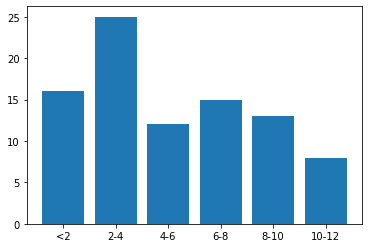

In [14]:
#distance bar chart thing; max 10.something, min 0ish, mean 5ish

#create bins
# dist_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# dist_labels = ['<1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11']

dist_bins = [0, 2, 4, 6, 8, 10, 12]
dist_labels = ['<2', '2-4', '4-6', '6-8', '8-10', '10-12']

college_df2['distance to C/U (bin)'] = pd.cut (college_df2['distance to C/U (miles)'],
                                               dist_bins,
                                               labels = dist_labels,
                                               include_lowest = True)

dist_series = college_df2.groupby(['distance to C/U (bin)'])['name'].count()

plt.bar (dist_labels, dist_series)

# college_df2['distance to C/U (miles)'].plot.box (grid = True)

#maria

In [15]:
#population demographics data, 1-2 images
#audrey

The slope is y = 0.67x + -17.5
The correlatation is 0.16
R Squared 0.03
{0.1426413392002697}


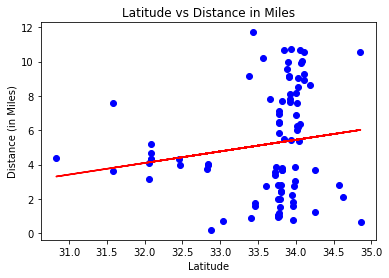

In [35]:
#alternative ideas:
#establish date
#possible statistical test

brewery_lat = college_df2['latitude']

brewery_dist = college_df2['distance to C/U (miles)']

plt.scatter(brewery_lat, brewery_dist, marker="o", facecolor="blue", edgecolors="blue")


#get the slope, intercept, rvalue, pvalue, and standard error
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(brewery_lat.astype(float), brewery_dist.astype(float))
regress_values = brewery_lat * slope + intercept


# #line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(brewery_lat,regress_values,"r-")

#get the correlation
correlation = round(st.pearsonr(brewery_lat.astype(float), brewery_dist.astype(float))[0],2)
r_sq= round(correlation**2,2)

plt.xlabel("Latitude")
plt.ylabel("Distance (in Miles)")
plt.title("Latitude vs Distance in Miles")
print(f'The slope is {line_eq}')
print(f'The correlatation is {correlation}')
print(f'R Squared {r_sq}')